
Valores nulos: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   P           40000 non-null  float64
 1   T           40000 non-null  float64
 2   Q           40000 non-null  float64
 3   SurfGeom_0  40000 non-null  float64
 4   SurfGeom_1  40000 non-null  float64
 5   SurfGeom_2  40000 non-null  float64
 6   Angles_0    40000 non-null  float64
 7   Angles_1    40000 non-null  float64
 8   Angles_2    40000 non-null  float64
 9   Angles_3    40000 non-null  float64
 10  Skin_0      40000 non-null  float64
 11  s2m_0       40000 non-null  float64
 12  s2m_1       40000 non-null  float64
 13  s2m_2       40000 non-null  float64
 14  SurfType_0  40000 non-null  int32  
 15  Result_0    40000 non-null  float64
 16  Result_1    40000 non-null  float64
 17  Result_2    40000 non-null  float64
 18  Result_3    40000 non-null  float64
 19  Result_

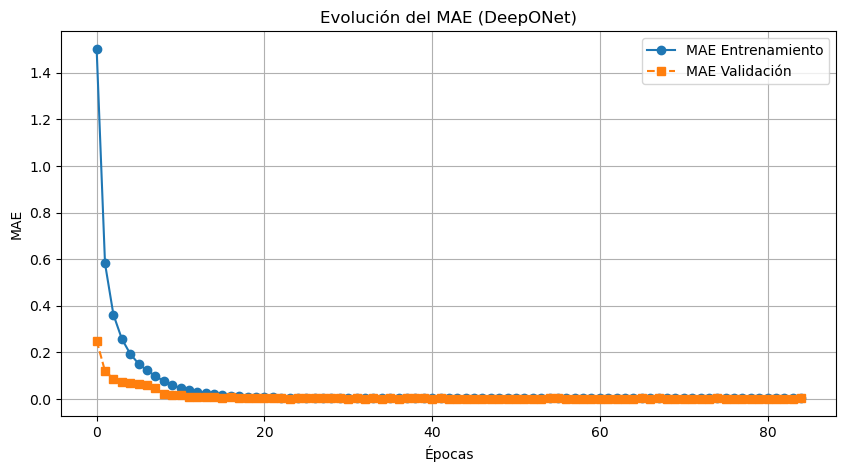

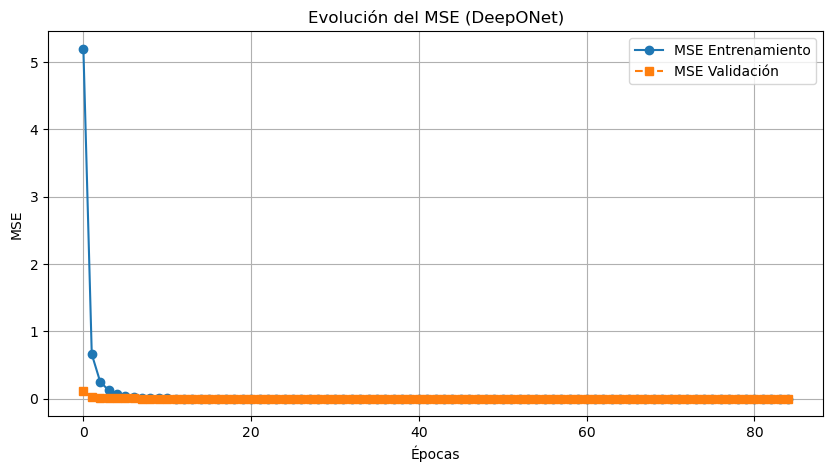

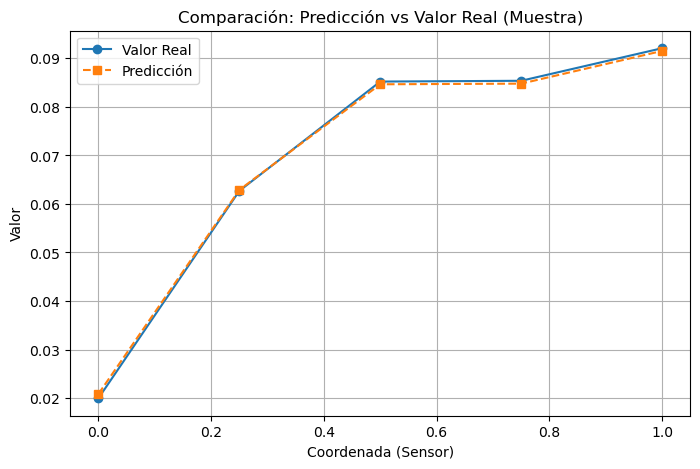


----- RESUMEN -----
Número de capas ocultas (branch): 3 con neuronas: [128, 64, 32]
Número de capas ocultas (trunk): 3 con neuronas: [128, 64, 32]
Learning rate: 0.0001
Batch size: 32
Training epochs ejecutadas: 85
Patience: 20
Epoch en la que se detuvo el entrenamiento (mejor epoch): 65
MSE: 0.0000
RMSE: 0.0020
MAE: 0.0014
R2 promedio: 0.8555


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import time

# ----------------------------
# 1. Carga y Preprocesamiento
# ----------------------------
# Cargar el CSV y eliminar la columna DateTimes
df = pd.read_csv('./dataset_rttov_rad.csv')
df = df.drop(columns=['DateTimes'])

# Convertir columnas de texto a arrays numéricos
P_values    = np.array([np.array(eval(row)) for row in df['P']])
T_values    = np.array([np.array(eval(row)) for row in df['T']])
Q_values    = np.array([np.array(eval(row)) for row in df['Q']])
CO2_values  = np.array([np.array(eval(row)) for row in df['CO2']])
Angles      = np.array([np.array(eval(row)) for row in df['Angles']])
SurfGeom    = np.array([np.array(eval(row)) for row in df['SurfGeom']])
Skin        = np.array([np.array(eval(row)) for row in df['Skin']])
s2m         = np.array([np.array(eval(row)) for row in df['s2m']])
SurfType    = np.array([np.array(eval(row)) for row in df['SurfType']])

# Calcular medias para algunas variables
P_mean   = np.mean(P_values, axis=1)
T_mean   = np.mean(T_values, axis=1)
Q_mean   = np.mean(Q_values, axis=1)
CO2_mean = np.mean(CO2_values, axis=1)

# Crear DataFrames para cada grupo de variables
SurfGeom_df = pd.DataFrame(SurfGeom, columns=[f"SurfGeom_{i}" for i in range(SurfGeom.shape[1])])
Angles_df   = pd.DataFrame(Angles,   columns=[f"Angles_{i}" for i in range(Angles.shape[1])])
Skin_df     = pd.DataFrame(Skin,     columns=[f"Skin_{i}" for i in range(Skin.shape[1])])
s2m_df      = pd.DataFrame(s2m,      columns=[f"s2m_{i}" for i in range(s2m.shape[1])])
SurfType_df = pd.DataFrame(SurfType, columns=[f"SurfType_{i}" for i in range(SurfType.shape[1])])

# Procesar la variable objetivo
Results    = np.array([np.array(eval(row)) for row in df['Result']])
results_df = pd.DataFrame(Results, columns=[f"Result_{i}" for i in range(Results.shape[1])])

# Crear DataFrame de estadísticas
stats_df = pd.DataFrame({
    "P": P_mean, 
    "T": T_mean, 
    "Q": Q_mean,
    "CO2": CO2_mean
})

# Concatenar todos los DataFrames
final_df = pd.concat([stats_df, SurfGeom_df, Angles_df, Skin_df, s2m_df, SurfType_df, results_df], axis=1)

# Depurar columnas: eliminar aquellas con poca variabilidad o redundantes
final_df = final_df.drop(columns=['Skin_1', 'Skin_2', 'Skin_3', 'Skin_4', 'Skin_5', 
                                   'Skin_6', 'Skin_7', 'Skin_8', 's2m_3', 's2m_4', 's2m_5',
                                   'SurfType_1', 'CO2'])

print("Valores nulos:", final_df.isnull().sum().sum())
final_df.info()

# Eliminar columnas redundantes según análisis previo
final_df = final_df.drop(columns=['SurfGeom_2','s2m_0','Angles_1'])

# ------------------------------
# 2. División de los Datos (Sin Escalado para DeepONet)
# ------------------------------
# Separamos X e Y
X = final_df.drop(columns=['Result_0','Result_1','Result_2','Result_3','Result_4']).copy()
Y = final_df[['Result_0','Result_1','Result_2','Result_3','Result_4']].copy()

# División en entrenamiento y prueba (80%/20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ---
# Se utiliza StandardScaler para la branch; si se prefiere no usarlo, comenta estas líneas.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------------------------------
# 3. Preparación de Inputs para la DeepONet (Trunk)
# ---------------------------------------------------
n_sensor = 5
trunk_coords = np.linspace(0, 1, n_sensor).reshape(n_sensor, 1)
trunk_train = np.repeat(trunk_coords[None, :, :], X_train_scaled.shape[0], axis=0)  # (n_train, 5, 1)
trunk_test  = np.repeat(trunk_coords[None, :, :], X_test_scaled.shape[0], axis=0)   # (n_test, 5, 1)

print("Shapes - X_train_scaled:", X_train_scaled.shape, "Y_train:", Y_train.shape, "trunk_train:", trunk_train.shape)

# -------------------------------------------------
# 4. Construcción de la DeepONet
# -------------------------------------------------
# Entrada de la branch (global)
branch_input = layers.Input(shape=(X_train_scaled.shape[1],), name='branch_input')
b = layers.Dense(128, activation='relu')(branch_input)
b = layers.BatchNormalization()(b)
b = layers.Dropout(0.1)(b)
b = layers.Dense(64, activation='relu')(b)
b = layers.BatchNormalization()(b)
b = layers.Dropout(0.1)(b)
b = layers.Dense(32, activation='relu')(b)
b = layers.BatchNormalization()(b)
branch_out = layers.Dense(32, activation='linear')(b)  # Salida: vector de dimensión 32

# Entrada de la trunk (local)
trunk_input = layers.Input(shape=(n_sensor, 1), name='trunk_input')

def trunk_net():
    model = keras.Sequential([
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='linear')
    ])
    return model

# Aplicamos el trunk_net de forma TimeDistributed
trunk_model = trunk_net()
trunk_out = layers.TimeDistributed(trunk_model)(trunk_input)  # (batch, n_sensor, 32)

# Repetir la salida de la branch para cada sensor
branch_out_tiled = layers.RepeatVector(n_sensor)(branch_out)  # (batch, n_sensor, 32)

# Producto punto entre branch y trunk para combinar la información global y local
output = layers.Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=-1))([branch_out_tiled, trunk_out])

# Definición y compilación del modelo DeepONet
deepONet_model = keras.Model(inputs=[branch_input, trunk_input], outputs=output)
deepONet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
deepONet_model.summary()

# -------------------------------------------------------
# 5. Entrenamiento y Evaluación del Modelo
# -------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time = time.time()
history = deepONet_model.fit([X_train_scaled, trunk_train], Y_train.values, 
                             epochs=100, batch_size=32, 
                             validation_data=([X_test_scaled, trunk_test], Y_test.values),
                             callbacks=[early_stop])
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.4f} segundos")

# Medir tiempo de inferencia
start_infer = time.time()
preds = deepONet_model.predict([X_test_scaled, trunk_test])
end_infer = time.time()
print(f"Tiempo de inferencia: {end_infer - start_infer:.4f} segundos")

# Calcular R^2 para cada salida y promedio
r2_scores = r2_score(Y_test.values, preds, multioutput='raw_values')
print("R^2 por salida:", r2_scores)

r2_avg = r2_score(Y_test.values, preds)
print("Coeficiente de Determinación (R² promedio):", r2_avg)

# -------------------------------------------------------
# 6. Plots de Evaluación y Resultados
# -------------------------------------------------------

# Plot de la evolución del MAE (Training y Validation)
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='MAE Entrenamiento', marker='o')
plt.plot(history.history['val_mae'], label='MAE Validación', marker='s', linestyle='dashed')
plt.title("Evolución del MAE (DeepONet)")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

# Plot de la evolución del MSE (Training y Validation)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='MSE Entrenamiento', marker='o')
plt.plot(history.history['val_loss'], label='MSE Validación', marker='s', linestyle='dashed')
plt.title("Evolución del MSE (DeepONet)")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# Plot de Predicción vs Valor Real para una muestra
# Se utiliza la primera muestra del conjunto de test
idx = 0  
plt.figure(figsize=(8,5))
plt.plot(trunk_coords, Y_test.values[idx], 'o-', label='Valor Real')
plt.plot(trunk_coords, preds[idx], 's--', label='Predicción')
plt.title("Comparación: Predicción vs Valor Real (Muestra)")
plt.xlabel("Coordenada (Sensor)")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------
# 7. Resumen de Hiperparámetros y Resultados
# -------------------------------------------------------
# Parámetros de la arquitectura:
n_hidden_branch = [128, 64, 32]   # Número de neuronas en cada capa oculta de la branch
n_hidden_trunk = [128, 64, 32]    # Número de neuronas en cada capa oculta de la trunk

learning_rate = 0.0001
batch_size = 32
training_epochs = len(history.history['loss'])  # Épocas ejecutadas
patience = 20  # Definido en EarlyStopping
best_epoch = np.argmin(history.history['val_loss']) + 1  # Época con menor pérdida de validación

# Evaluación final en el conjunto de test
test_loss, test_mae = deepONet_model.evaluate([X_test_scaled, trunk_test], Y_test.values, verbose=0)
rmse = np.sqrt(test_loss)

print("\n----- RESUMEN -----")
print(f"Número de capas ocultas (branch): {len(n_hidden_branch)} con neuronas: {n_hidden_branch}")
print(f"Número de capas ocultas (trunk): {len(n_hidden_trunk)} con neuronas: {n_hidden_trunk}")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print(f"Training epochs ejecutadas: {training_epochs}")
print(f"Patience: {patience}")
print(f"Epoch en la que se detuvo el entrenamiento (mejor epoch): {best_epoch}")
print(f"MSE: {test_loss:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R2 promedio: {r2_avg:.4f}")
